#### Wednesday, March 20, 2024

mamba activate t4nlpacv-2

Re-run test ... Yup, it still runs.

#### Wednesday, March 13, 2024

mamba activate t4nlpacv-2

This all runs in one pass ...



In [1]:
# only target the 4090 ...
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

# BERT Fine-Tuning Sentence Classification
Copyright 2023 Denis Rothman

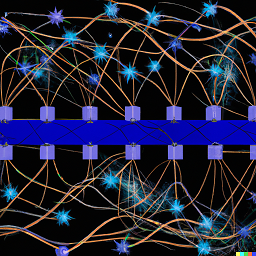

image copyright 2023, Denis Rothman & DALL-E

**The headings of the cells and the table of contents were modified to refer to the titles of the sections in the book.** The descriptions of the cells have been rewritten for educational purposes. Some additional information was added.

This notebook shows how to fine-tune a transformer model. Many pretrained and fine-tuned transformer models are available online. Some models, such as OpenAI LLMs, do not need to be fine-tuned for many tasks.

It is highly recommended to understand this notebook to grasp the architecture of transformer models.

Contributer: George Mihaila

[Reference Notebook by Chris McCormick and Nick Ryan](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX)

[Reference Article by Chris McCormick and Nick Ryan](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)

# Installing Hugging Face Transformers

In [2]:
try:
  import transformers
except:
  print("Installing transformers")
  #!pip -q install transformers

/home/rob/miniforge3/envs/t4nlpacv-2/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


#Importing the modules

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange  #for progress bars
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image #for image rendering

2024-03-20 17:04:36.743446: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 17:04:37.486837: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/rob/miniforge3/envs/t4nlpacv-2/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


#Specifying CUDA as the device for torch

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!nvidia-smi

/home/rob/miniforge3/envs/t4nlpacv-2/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Wed Mar 20 17:04:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050        Off | 00000000:01:00.0  On |                  N/A |
|  0%   57C    P0              N/A /  70W |    413MiB /  2048MiB |      7%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#Loading the CoLA dataset


**Corpus of Linguistic Accepability(CoLA)**

"...English sentences labeled as grammatical or ungrammatical from published linguistics literature..."

[Warstadt, A., Singh, A., & Bowman, S. R. (2018). Neural Network Acceptability Judgments.](https://arxiv.org/abs/1805.12471)

[Source of the datasets](https://nyu-mll.github.io/CoLA/)

In [5]:
import requests
from PIL import Image
from io import BytesIO

def get_image_from_github(image_name):
    # The base URL of the image files in the GitHub repository
    base_url = 'https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-and-Computer-Vision-3rd-Edition/main/Notebook%20images/05/'

    # Make the request
    response = requests.get(base_url + image_name)

    # Check if the request was successful
    if response.status_code == 200:
        # Read the image
        image = Image.open(BytesIO(response.content))

        # Return the image
        return image
    else:
        print(f'Error {response.status_code}: Could not access the image file.')
        return None

In [6]:
# !curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-and-Computer-Vision-3rd-Edition/master/Chapter05/in_domain_train.tsv --output "in_domain_train.tsv"

In [7]:
# !curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-and-Computer-Vision-3rd-Edition/master/Chapter05/out_of_domain_dev.tsv --output "out_of_domain_dev.tsv"

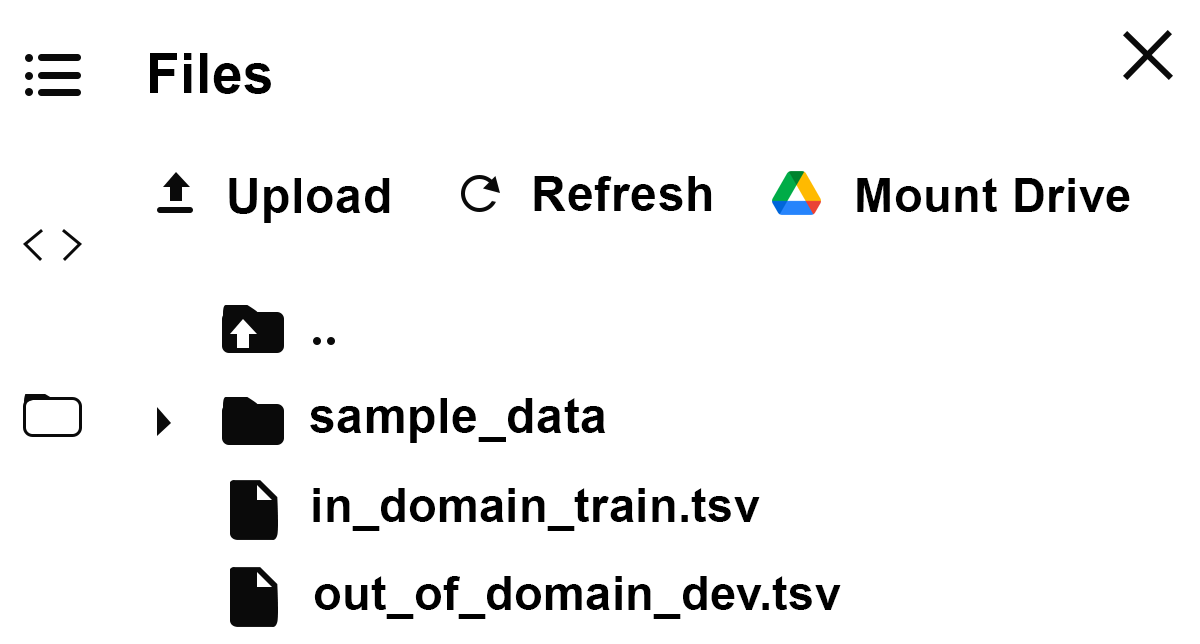

In [8]:
display(get_image_from_github('B19899_05_05.png') or print('Image not found'))

In [9]:
#source of dataset : https://nyu-mll.github.io/CoLA/

import pandas as pd
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape

(8551, 4)

In [10]:
df.sample(10)

,sentence_source,label,label_notes,sentence
5004,ks08,0,*,to please john is eager .
3693,ks08,1,NaN,i think that person we met last week is insane .
4542,ks08,1,NaN,"mary sang a song , but lee could not ."
111,cj99,1,NaN,i want to explain exactly why the more you eat...
5036,ks08,1,NaN,why she told him is unclear .
1141,r-67,0,*,he figured out it .
3020,l-93,1,NaN,i was hunting game in the woods .
277,cj99,1,NaN,"any senator becomes more corrupt , the more lo..."
47,gj04,1,NaN,the knee replacement candidate groaned up the ...
973,bc01,1,NaN,the writers could so believe the boy .


#Creating sentences, label lists, and adding BERT tokens

In [11]:
sentences = df.sentence.values

# Adding CLS and SEP tokens at the beginning and end of each sentence for BERT
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

#Activating the BERT tokenizer

**Note**: If the download fails, try again. Occasionally, the download function may timeout for several reasons, including server load.

You can also manually download 'bert-based-uncased' from the Hugging Face website: https://huggingface.co/bert-base-uncased

In [12]:
from transformers import BertTokenizer
try:
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    print("Tokenizer downloaded successfully.")
except Exception as e:
    print("An error occurred while downloading the tokenizer.")
    print(str(e))
    import traceback
    print(traceback.format_exc())

Tokenizer downloaded successfully.


In [13]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


#Processing the data

In [14]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

#Creating attention masks

In [15]:
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

#Splitting the data into training and validation sets

In [16]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

#Converting all the data into torch tensors

In [17]:
# Torch tensors are the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

#Selecting a batch size and creating an iterator

In [18]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


#BERT model configuration

In [19]:
# Initializing a BERT bert-base-uncased style configuration
from transformers import BertModel, BertConfig
configuration = BertConfig()

# Initializing a model from the bert-base-uncased style configuration
model = BertModel(configuration)

# Accessing the model configuration
configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



#Loading the Hugging Face BERT uncased base model

In [20]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model = nn.DataParallel(model)
model.to(device)
# 6m 32.3s

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, 

#Optimizer grouped parameters

In [21]:
#This code is taken from:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
# Separate the `weight` parameters from the `bias` parameters.
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01.
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0.
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},

    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
# Note - `optimizer_grouped_parameters` only includes the parameter values, not
# the names.

In [22]:
# Displaying a sample of the parameter_optimizer:  layer 3
layer_parameters = [p for n, p in model.named_parameters() if 'layer.3' in n]
print(layer_parameters)

[Parameter containing:
tensor([[ 0.0586, -0.0279,  0.0022,  ..., -0.0205,  0.0419,  0.0560],
        [-0.0011,  0.1283, -0.0564,  ..., -0.0514, -0.0199,  0.0516],
        [-0.0083,  0.0060, -0.0469,  ...,  0.0569, -0.0073, -0.0616],
        ...,
        [ 0.0118,  0.0645, -0.0159,  ..., -0.0027, -0.0031, -0.0141],
        [ 0.0029,  0.0531,  0.0221,  ..., -0.0047,  0.0399,  0.0344],
        [ 0.0512,  0.0246,  0.0077,  ...,  0.0108,  0.0262,  0.0081]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([ 9.7401e-02, -1.9291e-01,  4.3323e-02,  1.7938e-01, -8.0236e-02,
         2.4005e-01, -1.1202e-01, -7.8751e-02,  1.3820e-01, -2.4162e-01,
         1.9788e-01, -3.2046e-01,  3.5266e-02,  5.7152e-01, -5.9514e-02,
        -2.5558e-02,  9.7958e-02, -4.7495e-02, -2.0452e-01,  3.0384e-04,
         3.0269e-01,  4.9826e-02, -2.9197e-02,  2.3859e-01,  1.9353e-01,
         1.0818e-01,  2.7912e-01,  6.2726e-02, -1.7285e-01,  4.8728e-02,
         1.9279e-02, -6.0480e-01,  3.9

In [23]:
# Displaying names of parameters for which weight decay is not applied
no_decay

['bias', 'LayerNorm.weight']

In [24]:
# Displaying the list of the two dictionaries
small_sample = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)][:2],
     'weight_decay_rate': 0.1},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)][:2],
     'weight_decay_rate': 0.0}
]

for i, group in enumerate(small_sample):
    print(f"Group {i+1}:")
    print(f"Weight decay rate: {group['weight_decay_rate']}")
    for j, param in enumerate(group['params']):
        print(f"Parameter {j+1}: {param}")

Group 1:
Weight decay rate: 0.1
Parameter 1: Parameter containing:
tensor([[-0.0102, -0.0615, -0.0265,  ..., -0.0199, -0.0372, -0.0098],
        [-0.0117, -0.0600, -0.0323,  ..., -0.0168, -0.0401, -0.0107],
        [-0.0198, -0.0627, -0.0326,  ..., -0.0165, -0.0420, -0.0032],
        ...,
        [-0.0218, -0.0556, -0.0135,  ..., -0.0043, -0.0151, -0.0249],
        [-0.0462, -0.0565, -0.0019,  ...,  0.0157, -0.0139, -0.0095],
        [ 0.0015, -0.0821, -0.0160,  ..., -0.0081, -0.0475,  0.0753]],
       device='cuda:0', requires_grad=True)
Parameter 2: Parameter containing:
tensor([[ 1.7505e-02, -2.5631e-02, -3.6642e-02,  ...,  3.3437e-05,
          6.8312e-04,  1.5441e-02],
        [ 7.7580e-03,  2.2613e-03, -1.9444e-02,  ...,  2.8910e-02,
          2.9753e-02, -5.3247e-03],
        [-1.1287e-02, -1.9644e-03, -1.1573e-02,  ...,  1.4908e-02,
          1.8741e-02, -7.3140e-03],
        ...,
        [ 1.7418e-02,  3.4903e-03, -9.5621e-03,  ...,  2.9599e-03,
          4.3435e-04, -2.6949e-

#The hyperparameters for the training loop

In [25]:
# optimizer = BertAdam(optimizer_grouped_parameters,
#                      lr=2e-5,
#                      warmup=.1)

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

/home/rob/miniforge3/envs/t4nlpacv-2/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
#Creating the Accuracy Measurement Function
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

#The training loop

In [27]:
t = []

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()

    # Update the learning rate.
    scheduler.step()


    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

  # 1m 20.2s

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.524466422769044


Epoch:  25%|██▌       | 1/4 [00:20<01:00, 20.25s/it]

Validation Accuracy: 0.7935956790123456
Train loss: 0.3340593390012183


Epoch:  50%|█████     | 2/4 [00:40<00:40, 20.11s/it]

Validation Accuracy: 0.8113425925925926
Train loss: 0.1956462467792618


Epoch:  75%|███████▌  | 3/4 [01:00<00:20, 20.12s/it]

Validation Accuracy: 0.8302469135802469
Train loss: 0.12603862831732296


Epoch: 100%|██████████| 4/4 [01:20<00:00, 20.13s/it]

Validation Accuracy: 0.8290895061728395


#Training evaluation

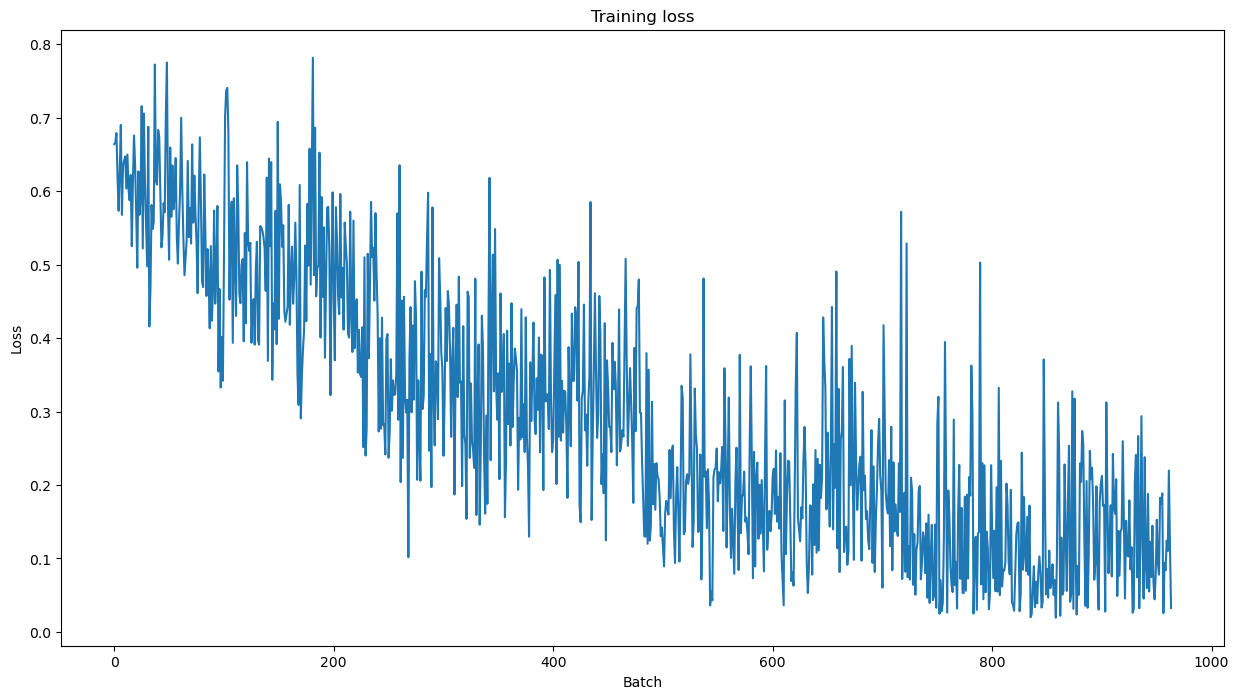

In [28]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

#Predicting and evaluating using the holdout dataset

In [29]:
#loading the holdout dataset
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [30]:
df.shape

(516, 4)

In [31]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [32]:
#Softmax logits
import numpy as np

def softmax(logits):
    e = np.exp(logits)
    return e / np.sum(e)

In [33]:
import torch
import numpy as np

# Put model in evaluation mode
model.eval()

# Tracking variables
raw_predictions, predicted_classes, true_labels = [], [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = outputs['logits'].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Convert input_ids back to words
  b_input_ids = b_input_ids.to('cpu').numpy()
  batch_sentences = [tokenizer.decode(input_ids, skip_special_tokens=True) for input_ids in b_input_ids]

  # Apply softmax function to convert logits into probabilities
  probabilities = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)

  # The predicted class is the one with the highest probability
  batch_predictions = np.argmax(probabilities, axis=1)

  # Print the sentences and the corresponding predictions for this batch
  for i, sentence in enumerate(batch_sentences):
    print(f"Sentence: {sentence}")
    print(f"Prediction: {logits[i]}")
    print(f"Sofmax probabilities", softmax(logits[i]))
    print(f"Prediction: {batch_predictions[i]}")
    print(f"True label: {label_ids[i]}")

  # Store raw predictions, predicted classes and true labels
  raw_predictions.append(logits)
  predicted_classes.append(batch_predictions)
  true_labels.append(label_ids)

Sentence: somebody just left - guess who.
Prediction: [-2.4426143  2.4646685]
Sofmax probabilities [0.0073383 0.9926617]
Prediction: 1
True label: 1
Sentence: they claimed they had settled on something, but it wasn't clear what they had settled on.
Prediction: [-2.6457787  2.2948308]
Sofmax probabilities [0.00709948 0.9929005 ]
Prediction: 1
True label: 1
Sentence: if sam was going, sally would know where.
Prediction: [-2.2808416  2.2223651]
Sofmax probabilities [0.01095215 0.9890478 ]
Prediction: 1
True label: 1
Sentence: they're going to serve the guests something, but it's unclear what.
Prediction: [-2.5595624  2.5310888]
Sofmax probabilities [0.00611637 0.99388367]
Prediction: 1
True label: 1
Sentence: she's reading. i can't imagine what.
Prediction: [-1.4054266  1.7333721]
Sofmax probabilities [0.04153492 0.95846504]
Prediction: 1
True label: 1
Sentence: john said joan saw someone from her graduating class.
Prediction: [-2.8077855  2.47663  ]
Sofmax probabilities [0.00504442 0.994

#Evaluating using the Matthews Correlation Coefficient

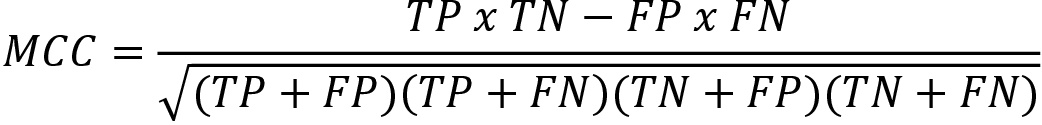

In [34]:
display(get_image_from_github('B19899_05_005.png') or print('Image not found'))

In [35]:
from sklearn.metrics import matthews_corrcoef

# Initialize an empty list to store the Matthews correlation coefficient for each batch
matthews_set = []

# Iterate over each batch
for i in range(len(true_labels)):
  # Calculate the Matthews correlation coefficient for this batch

  # true_labels[i] are the true labels for this batch
  # predicted_classes[i] are the predicted classes for this batch
  # We don't need to use np.argmax because predicted_classes already contains the predicted classes

  matthews = matthews_corrcoef(true_labels[i], predicted_classes[i])

  # Add the result to our list
  matthews_set.append(matthews)

# Now matthews_set contains the Matthews correlation coefficient for each batch

The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches.


# Matthews Correlation Coefficient evaluation for the whole dataset

In [36]:
from sklearn.metrics import matthews_corrcoef

# Flatten the true_labels and predicted_classes list of lists into single lists
true_labels_flattened = [label for batch in true_labels for label in batch]
predicted_classes_flattened = [pred for batch in predicted_classes for pred in batch]

# Calculate the MCC for the entire set of predictions
mcc = matthews_corrcoef(true_labels_flattened, predicted_classes_flattened)

print(f"MCC: {mcc}")

MCC: 0.534936021898104


# Saving the model

When a model is wrapped in DataParallel for multi-GPU training in PyTorch, the original model becomes an attribute of the DataParallel object.

When saving files in Google Colab, store them, as files in the Colab environment are discarded once the session ends.

The saved model can be large.

In this case, one solution is to mount Google Drive:
```
from google.colab import drive
drive.mount('/content/drive')
```

Then save the files in the ```/content/model``` directory to Google Drive.

For example:
```
! cp /content/model/*.* drive/MyDrive/files/model_C5
```



In [37]:
# Specify a directory to save your model and tokenizer
save_directory = "../content/model"


# If your model is wrapped in DataParallel, access the original model using .module and then save
if isinstance(model, torch.nn.DataParallel):
    model.module.save_pretrained(save_directory)
else:
    model.save_pretrained(save_directory)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

('../content/model/tokenizer_config.json',
 '../content/model/special_tokens_map.json',
 '../content/model/vocab.txt',
 '../content/model/added_tokens.json')

The saved /content/model director contains:

1. `tokenizer_config.json` - configuration details specific to the tokenizer.
2. `special_tokens_map.json` - mappings for any special tokens.
3. `vocab.txt` - the vocabulary of tokens that the tokenizer can recognize.
4. `added_tokens.json` - any tokens that were added to the tokenizer after its initial creation.



# Creating an interface for the trained model



In [38]:
# Standalone run
"""
Uncomment the following code if you want to run
the program in a new session after having saved the model.

You can start and continue the notebook by first running this cell and then the following ones.
"""
'''
# mount Google Drive, for example, or other source
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p /content/model/model/

! cp drive/MyDrive/files/model_C5/*.* /content/model

#install transformers
!pip install Transformers

from transformers import BertTokenizer, BertForSequenceClassification

# Directory where the model and tokenizer were saved
load_directory = "/content/model/"

# Load the model
model = BertForSequenceClassification.from_pretrained(load_directory)

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
'''

'\n# mount Google Drive, for example, or other source\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\n\n!mkdir -p /content/model/model/\n\n! cp drive/MyDrive/files/model_C5/*.* /content/model\n\n#install transformers\n!pip install Transformers\n\nfrom transformers import BertTokenizer, BertForSequenceClassification\n\n# Directory where the model and tokenizer were saved\nload_directory = "/content/model/"\n\n# Load the model\nmodel = BertForSequenceClassification.from_pretrained(load_directory)\n\n# Load the tokenizer\ntokenizer = BertTokenizer.from_pretrained(\'bert-base-uncased\', do_lower_case=True)\n'

In [39]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

model.eval()  # set the model to evaluation mode

DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, 

building the prediction function

In [40]:
def predict(sentence, model, tokenizer):
    # Add [CLS] and [SEP] tokens
    sentence = "[CLS] " + sentence + " [SEP]"
    # Tokenize the sentence
    tokenized_text = tokenizer.tokenize(sentence)

    # Convert token to vocabulary indices
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    # Define a segment id (0 for all tokens; we don't have a second sequence)
    segments_ids = [0] * len(tokenized_text)

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    # Make prediction
    with torch.no_grad():
        outputs = model(tokens_tensor, token_type_ids=segments_tensors)
        logits = outputs.logits
        # You might want to convert logits to probabilities or extract the predicted label.
        predicted_label = torch.argmax(logits, dim=1).item()

    return predicted_label


## Interacting with the model

To begin interacting with the live classifications:  
   
a) enter a sentence that is correct: "They went to the market."       
b) then enter a sentence that is incorrect: "They no go market."    
c) then try any sentence you wish to explore the scope and limitations.

Click on `Interpret `to see the explanations of an error.   
Click on `Flag` to save the errors in log.csv file (see File Browser)    
Click on `Clear` to enter a new sentence.   

!pip install --upgrade typing_extensions

In [41]:
# !pip install ipywidgets

In [42]:
import ipywidgets as widgets
from IPython.display import display

def model_predict_interface(sentence):
    prediction = predict(sentence, model, tokenizer)
    if prediction == 0:
        return "Grammatically Incorrect"
    elif prediction == 1:
        return "Grammatically Correct"
    else:
        return f"Label: {prediction}"

text_input = widgets.Textarea(
    placeholder='Type something',
    description='Sentence:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='50px')  # Adjust width and height here
)

output_label = widgets.Label(
    value='',
    layout=widgets.Layout(width='100%', height='25px'),  # Adjust width and height here
    style={'description_width': 'initial'}
)

def on_text_submit(change):
    output_label.value = model_predict_interface(change.new)

text_input.observe(on_text_submit, names='value')

display(text_input, output_label)

Textarea(value='', description='Sentence:', layout=Layout(height='50px', width='100%'), placeholder='Type some…

Label(value='', layout=Layout(height='25px', width='100%'), style=LabelStyle(description_width='initial'))